In [7]:
import sys

sys.path.append("..")

from data_loading import *
from maths import isa_temperature, height_from_pressure
from merra2 import get_pressure_from_level


In [18]:
n = 10000000
estimate_quantile = None
variables = ("V", )

means = {"U": 5.589, "V": 0.018, "T": 235.745, "P": 37590}
stds = {"U": 9.832, "V": 3.232, "T": 26.735, "P": 26545}


In [19]:
if estimate_quantile is None:
    data = pd.read_feather(f"subset/{''.join(variables)}-{n}.ft")
else:
    data = pd.read_feather(f"subset/{''.join(variables)}-{estimate_quantile}-{n}.ft")

df = data.copy()

NORMALIZED = False
GEOGRAPHICAL_MATRIX = 1
GEOGRAPHICAL = False
CYCLIC_TIME = False
CYCLIC_COORDINATES = False
BAROMETRIC = False
MATHUR2022 = False

data.head()


,time,lev,lat,lon,V
0,2840,0,251,489,5.011719
1,835,0,294,398,-0.305176
2,941,0,61,13,1.799805
3,549,0,328,27,2.947266
4,2385,0,238,253,-0.740723


In [6]:
BAROMETRIC = True

df["isa_pressure"] = (100 * df["lev"].apply(get_pressure_from_level))
df["altitude"] = df["isa_pressure"].apply(height_from_pressure)
df["isa_temperature"] = df["altitude"].apply(isa_temperature)

df["isa_pressure"] = ((df["isa_pressure"] - means["P"]) / stds["P"]).astype("float16")
df["altitude"] = (df["altitude"] / 18000).astype("float16")
df["isa_temperature"] = ((df["isa_temperature"] - means["T"]) / stds["T"]).astype("float16")

df.head()

KeyboardInterrupt: 

In [20]:
NORMALIZED = True

df["lat"] = (data["lat"] * 0.5) - 90
df["lat"] /= 90
df["lon"] = (data["lon"] * 0.625) - 180
df["lon"] /= 180
df["lev"] /= 36

df["lev"] = df["lev"].astype("float16")
df["lat"] = df["lat"].astype("float16")
df["lon"] = df["lon"].astype("float16")

for var in variables:
    df[var] -= means[var]
    df[var] /= stds[var]

    try:
        df[f"{var}_est"] -= means[var]
        df[f"{var}_est"] /= stds[var]
    except KeyError:
        pass

df["day %"] = ((data["time"] % 8) / 8).astype("float16")
df["year %"] = (data["time"] / 2920).astype("float16")
del df["time"]

df.head()


,lev,lat,lon,V,day %,year %
0,0.0,0.394531,0.697754,1.543945,0.000,0.972656
1,0.0,0.633301,0.381836,-0.099976,0.375,0.285889
2,0.0,-0.661133,-0.955078,0.551270,0.625,0.322266
3,0.0,0.822266,-0.906250,0.906250,0.625,0.187988
4,0.0,0.322266,-0.121521,-0.234741,0.125,0.816895


In [21]:

CYCLIC_TIME = True

df["sin_day"] = np.sin(df["day %"] * np.pi * 2)
df["cos_day"] = np.cos(df["day %"] * np.pi * 2)
df["sin_year"] = np.sin(df["year %"] * np.pi * 2)
df["cos_year"] = np.cos(df["year %"] * np.pi * 2)

df.head()


,lev,lat,lon,V,day %,year %,sin_day,cos_day,sin_year,cos_year
0,0.0,0.394531,0.697754,1.543945,0.000,0.972656,0.000000,1.000000,-0.172974,0.984863
1,0.0,0.633301,0.381836,-0.099976,0.375,0.285889,0.707520,-0.706543,0.974609,-0.223267
2,0.0,-0.661133,-0.955078,0.551270,0.625,0.322266,-0.706055,-0.708008,0.899414,-0.437256
3,0.0,0.822266,-0.906250,0.906250,0.625,0.187988,-0.706055,-0.708008,0.924805,0.380371
4,0.0,0.322266,-0.121521,-0.234741,0.125,0.816895,0.707031,0.707520,-0.913086,0.408203


In [22]:
CYCLIC_COORDINATES = True

df["sin_lat"] = np.sin(df["lat"] * np.pi)
df["cos_lat"] = np.cos(df["lat"] * np.pi)
df["sin_lon"] = np.sin(df["lon"] * np.pi)
df["cos_lon"] = np.cos(df["lon"] * np.pi)

df.head()

,lev,lat,lon,V,day %,year %,sin_day,cos_day,sin_year,cos_year,sin_lat,cos_lat,sin_lon,cos_lon
0,0.0,0.394531,0.697754,1.543945,0.000,0.972656,0.000000,1.000000,-0.172974,0.984863,0.945312,0.325439,0.813477,-0.581543
1,0.0,0.633301,0.381836,-0.099976,0.375,0.285889,0.707520,-0.706543,0.974609,-0.223267,0.913574,-0.406250,0.931641,0.363037
2,0.0,-0.661133,-0.955078,0.551270,0.625,0.322266,-0.706055,-0.708008,0.899414,-0.437256,-0.875000,-0.484131,-0.141113,-0.990234
3,0.0,0.822266,-0.906250,0.906250,0.625,0.187988,-0.706055,-0.708008,0.924805,0.380371,0.530762,-0.847656,-0.291504,-0.956543
4,0.0,0.322266,-0.121521,-0.234741,0.125,0.816895,0.707031,0.707520,-0.913086,0.408203,0.847656,0.530273,-0.372314,0.928223


In [23]:
GEOGRAPHICAL = True

frland = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAND",
                                         time=0, level=0, folder="raw").astype("float16")
frocean = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FROCEAN",
                                          time=0, level=0, folder="raw").astype("float16")
frlake = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAKE",
                                         time=0, level=0, folder="raw").astype("float16")
frlandice = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLANDICE",
                                            time=0, level=0, folder="raw").astype("float16")
phis = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="PHIS",
                                       time=0, level=0, folder="raw")
sgh = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="SGH",
                                      time=0, level=0, folder="raw")

phis -= phis.mean()
phis /= phis.std()
phis = phis.astype("float16")

sgh -= sgh.mean()
sgh /= sgh.std()
sgh = sgh.astype("float16")

indices = data[["lat", "lon"]].values.T

df["frland"] = frland[*indices]
df["frocean"] = frocean[*indices]
df["frlake"] = frlake[*indices]
df["frlandice"] = frlandice[*indices]
df["phis"] = phis[*indices]
df["sgh"] = sgh[*indices]

for coord in ([0, 1], [0, -1], [1, 0], [-1, 0], [1, 1], [-1, -1], [1, -1], [-1, 1]):
    indices = data[["lat", "lon"]]
    indices.loc[:, "lat"] = (indices["lat"] + coord[0]) % 361
    indices.loc[:, "lon"] = (indices["lon"] + coord[1]) % 576
    indices = indices.values.T

    df[f"frland_{coord}"] = frland[*indices]
    df[f"frlandice_{coord}"] = frlandice[*indices]
    df[f"phis_{coord}"] = phis[*indices]

df.head()


,lev,lat,lon,V,day %,year %,sin_day,cos_day,sin_year,cos_year,...,"phis_[1, 1]","frland_[-1, -1]","frlandice_[-1, -1]","phis_[-1, -1]","frland_[1, -1]","frlandice_[1, -1]","phis_[1, -1]","frland_[-1, 1]","frlandice_[-1, 1]","phis_[-1, 1]"
0,0.0,0.394531,0.697754,1.543945,0.000,0.972656,0.000000,1.000000,-0.172974,0.984863,...,-0.446045,0.000000,0.0,-0.447510,0.000000,0.0,-0.447754,0.435059,0.0,-0.423584
1,0.0,0.633301,0.381836,-0.099976,0.375,0.285889,0.707520,-0.706543,0.974609,-0.223267,...,-0.371094,0.998535,0.0,-0.305420,0.948242,0.0,-0.366455,0.997559,0.0,-0.318604
2,0.0,-0.661133,-0.955078,0.551270,0.625,0.322266,-0.706055,-0.708008,0.899414,-0.437256,...,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754
3,0.0,0.822266,-0.906250,0.906250,0.625,0.187988,-0.706055,-0.708008,0.924805,0.380371,...,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754
4,0.0,0.322266,-0.121521,-0.234741,0.125,0.816895,0.707031,0.707520,-0.913086,0.408203,...,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754,0.000000,0.0,-0.447754


In [8]:
MATHUR2022 = True

assert BAROMETRIC
assert NORMALIZED
assert CYCLIC_TIME
assert not CYCLIC_COORDINATES
assert GEOGRAPHICAL

del df["lev"], df["day %"], df["year %"]

In [14]:
df.dtypes

lev          float16
lat          float16
lon          float16
V            float16
day %        float16
year %       float16
sin_day      float16
cos_day      float16
sin_year     float16
cos_year     float16
sin_lat      float16
cos_lat      float16
sin_lon      float16
cos_lon      float16
frland       float16
frocean      float16
frlake       float16
frlandice    float16
phis         float16
sgh          float16
dtype: object

In [24]:
GEOGRAPHICAL_MATRIX = 3

In [25]:
if MATHUR2022:
    dataset = "MATHUR2022"
else:
    dataset = "N" if NORMALIZED else ""
    dataset += f"{GEOGRAPHICAL_MATRIX}G" if GEOGRAPHICAL else ""
    dataset += "CT" if CYCLIC_TIME else ""
    dataset += "CC" if CYCLIC_COORDINATES else ""
    dataset += "B" if BAROMETRIC else ""

if estimate_quantile is None:
    output = f"subset/{''.join(variables)}-{dataset}-{n}.ft"
else:
    output = f"subset/{''.join(variables)}-{dataset}-{estimate_quantile}-{n}.ft"
df.to_feather(output)
print("Saved to", output)

Saved to subset/V-N3GCTCC-10000000.ft


In [9]:
df.astype("float32").describe()


,lev,lat,lon,U,day %,year %,sin_day,cos_day,sin_year,cos_year,frland,frocean,frlake,frlandice,phis,sgh
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,4.860707e-01,2.462973e-05,-1.871183e-03,-4.416984e-04,4.374707e-01,4.998518e-01,1.729702e-04,-4.242568e-04,1.247783e-04,-1.372756e-04,2.208387e-01,6.579232e-01,4.544531e-03,1.166930e-01,-5.972622e-06,4.212677e-04
std,2.884620e-01,5.788935e-01,5.773609e-01,1.000237e+00,2.863863e-01,2.887040e-01,7.070776e-01,7.071832e-01,7.073098e-01,7.069100e-01,3.984419e-01,4.616012e-01,2.920654e-02,3.150236e-01,9.998747e-01,1.000840e+00
min,0.000000e+00,-1.000000e+00,-1.000000e+00,-5.066406e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.087891e-01,-3.937988e-01
25%,2.500000e-01,-5.000000e-01,-5.034180e-01,-6.635742e-01,1.250000e-01,2.500000e-01,-7.060547e-01,-7.080078e-01,-7.084961e-01,-7.065430e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.477539e-01,-3.937988e-01
50%,4.721680e-01,0.000000e+00,0.000000e+00,-2.148438e-01,5.000000e-01,4.997559e-01,9.675026e-04,-1.451492e-03,9.675026e-04,4.837513e-04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.477539e-01,-3.937988e-01
75%,7.221680e-01,5.000000e-01,4.965820e-01,4.860840e-01,6.250000e-01,7.500000e-01,7.070312e-01,7.075195e-01,7.075195e-01,7.060547e-01,9.741211e-02,1.000000e+00,0.000000e+00,0.000000e+00,-1.678467e-01,-1.477051e-01
max,9.721680e-01,1.000000e+00,9.965820e-01,7.804688e+00,8.750000e-01,9.995117e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.078125e+00,1.228906e+01


In [18]:
df = pd.read_feather(f"subset/{''.join(variables)}-NGCTCC-{n}.ft")
# df["V"] *= stds["V"]
# df["V"] += means["V"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


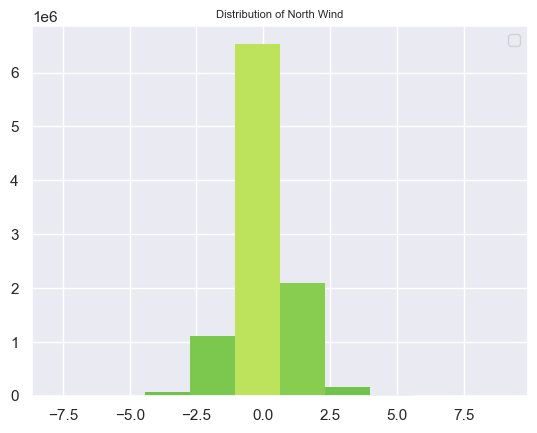

In [19]:
from plot import plot_histogram
plot_histogram([{"data": df["V"]}], title="Distribution of North Wind")